# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext101_32x4d'

HEIGHT = 137
WIDTH = 236
FACTOR = 0.70
HEIGHT_NEW = int(HEIGHT * FACTOR)
WIDTH_NEW = int(WIDTH * FACTOR)

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 1e-3
WD = 1e-5
DP = 0.3
HDIM = 1024
outdir = Path('{}_2lr_LR{}_WD{}_DP{}_HDIM{}_imagenetch3-simpleaug-fixlr-rs'.format(model_name, LR, WD, DP, HDIM))

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 31.6 s, sys: 30.1 s, total: 1min 1s
Wall time: 6.9 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 68),
 ('arch', 59),
 ('out', 50),
 ('HDIM', 28),
 ('HEIGHT', 28),
 ('HEIGHT_NEW', 28),
 ('WIDTH', 28),
 ('WIDTH_NEW', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('DP', 24),
 ('FACTOR', 24),
 ('LR', 24),
 ('TH', 24),
 ('WD', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

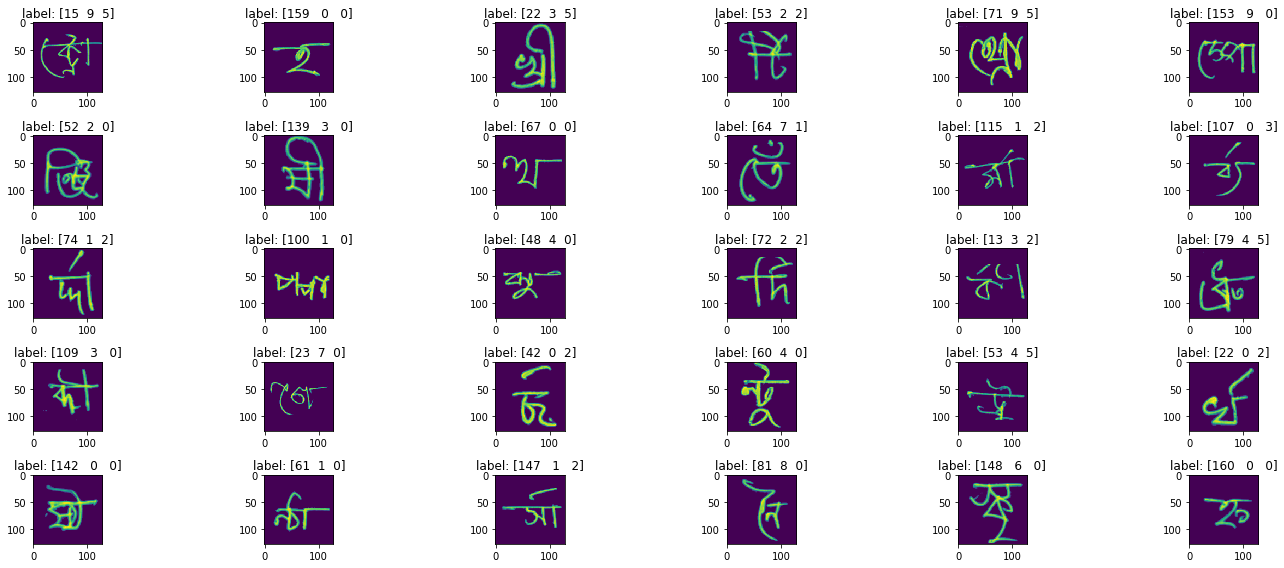

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

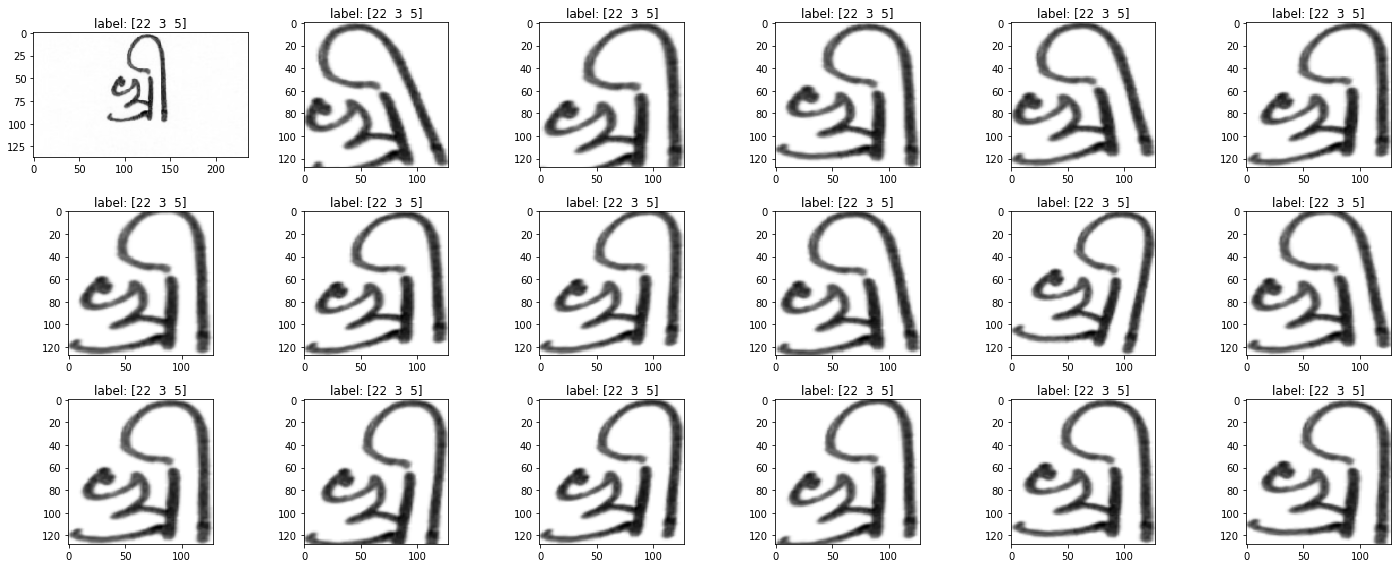

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

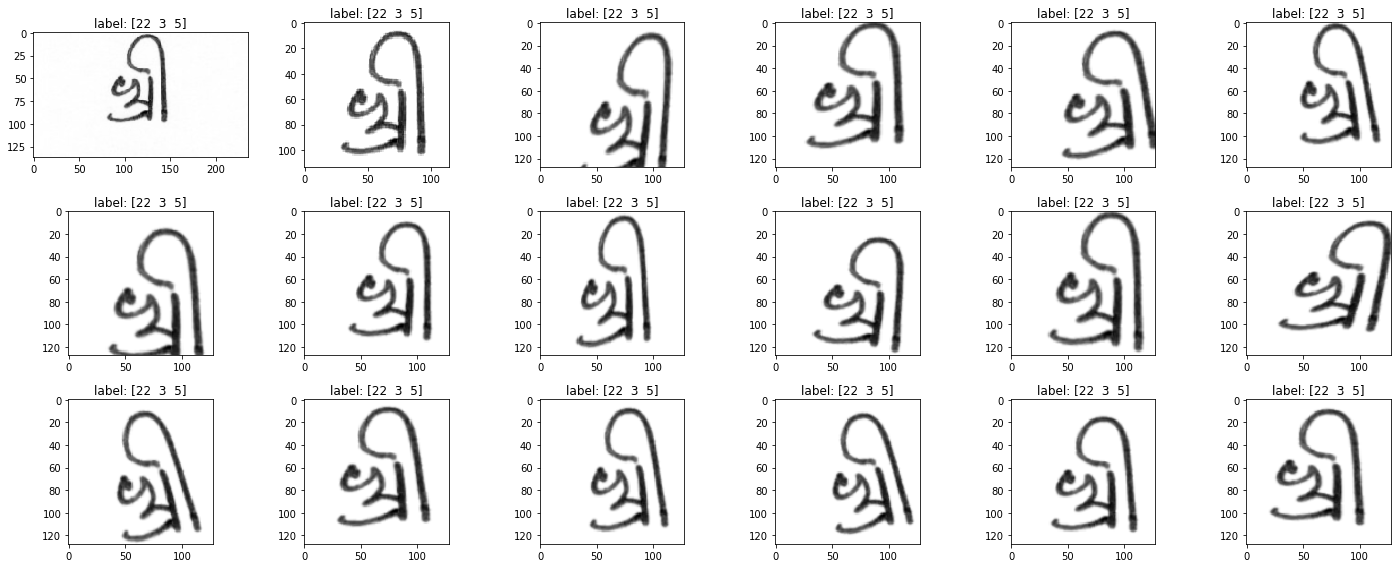

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

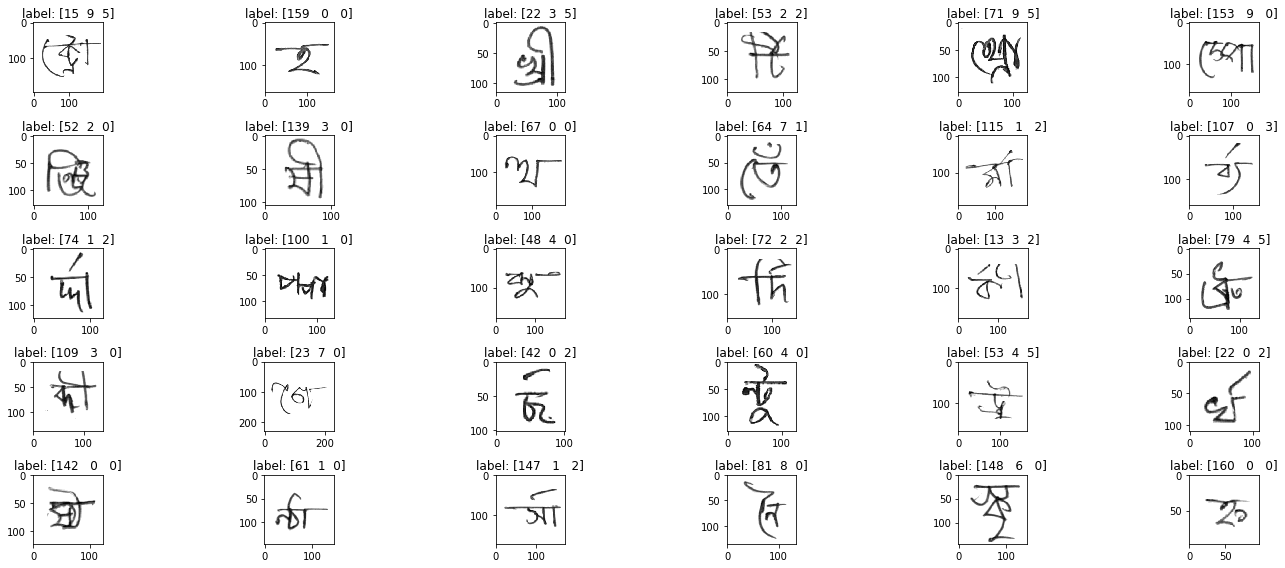

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

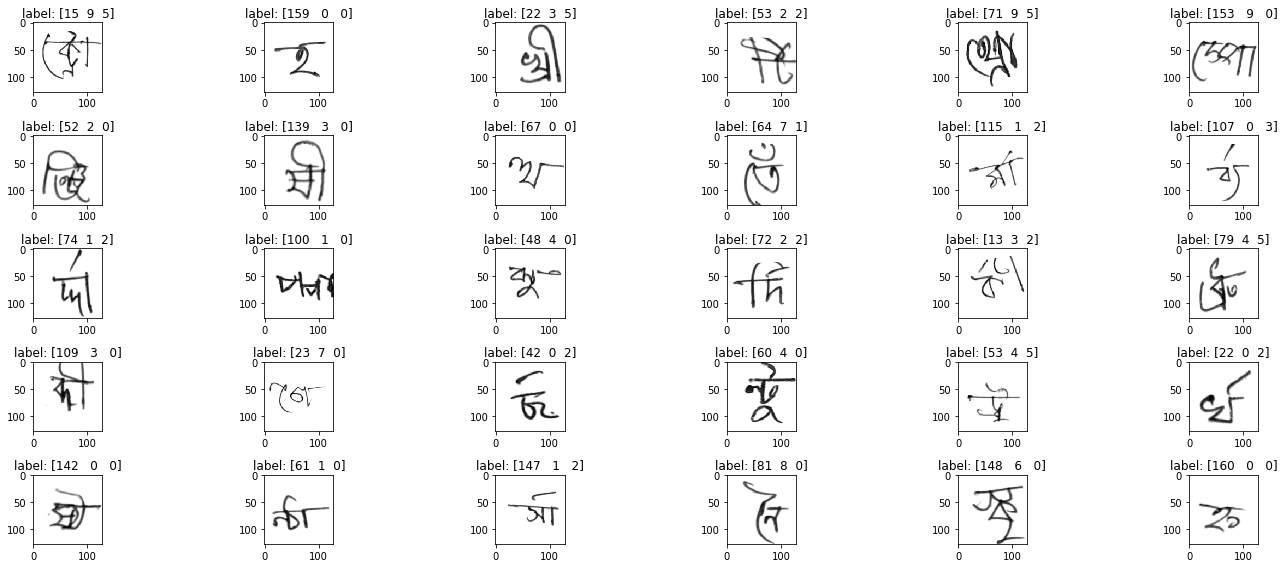

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(
    size=(image_size, image_size), cutout_ratio=0.5) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

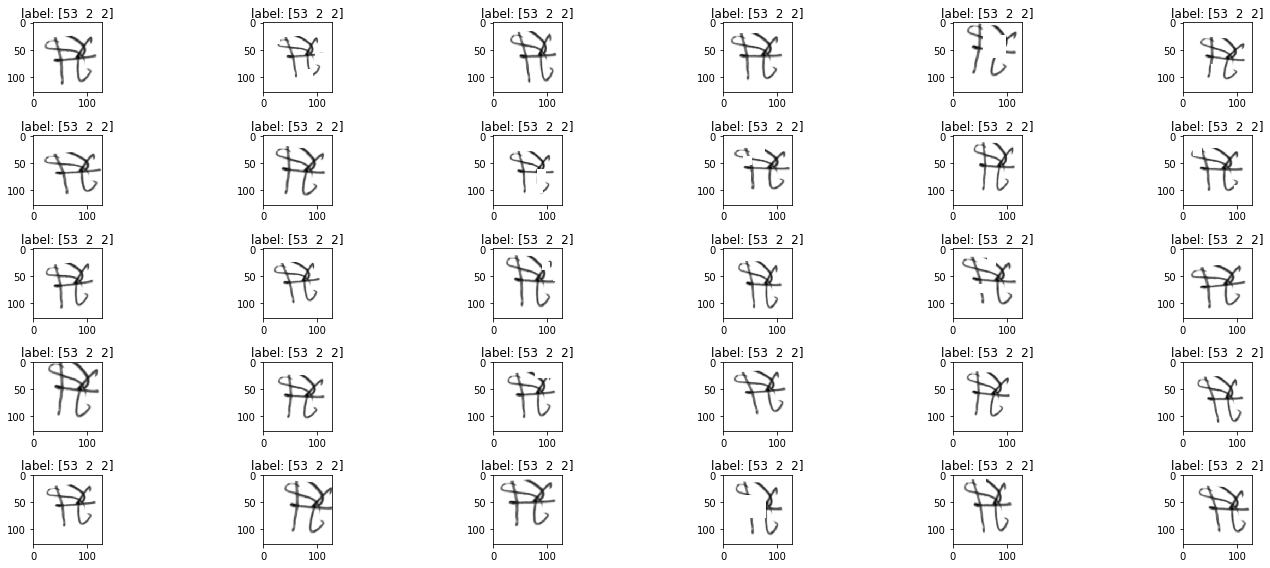

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

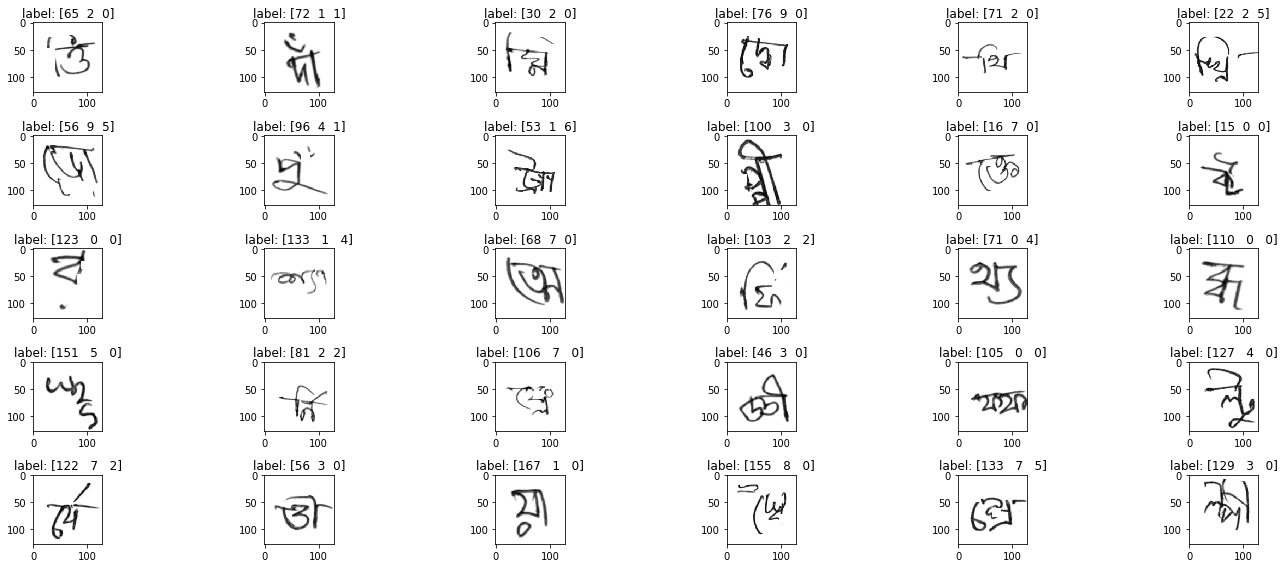

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

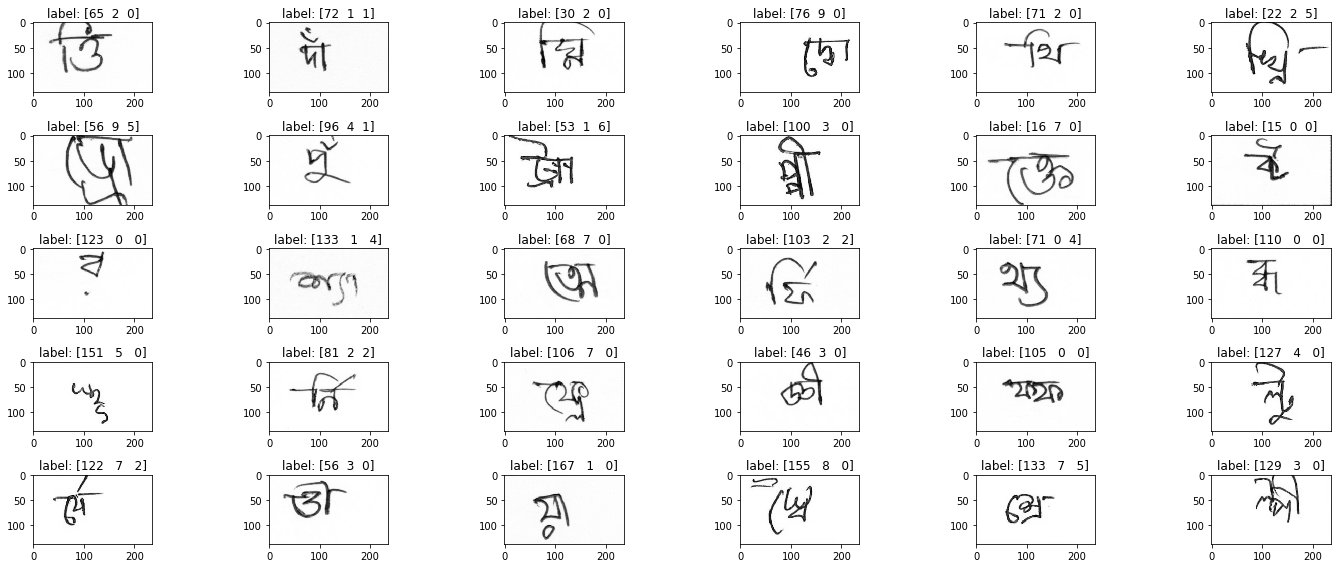

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [34]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [35]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         print(self.base_model)
        names = []
        for name, child in self.base_model.named_children():
            names.append(name)
            
        arch = self.base_model
        arch = list(arch.children())
        #saving the weights of the forst conv in w
        w = arch[0][0].weight
        #creating new Conv2d to accept 1 channel 
        arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #substituting weights of newly created Conv2d with w from but we have to take mean
        #to go from  3 channel to 1
        arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
        arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
#         print(arch)
        self.base_model = arch
#         print("#######################################")
#         print(self.base_model)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        
        hdim = HDIM
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.base_model.layer0(x)
        h = self.base_model.layer1(h)
        h = self.base_model.layer2(h)
        h = self.base_model.layer3(h)
        h = self.base_model.layer4(h)
        
        h = self.classifer(h)

        return h

In [38]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [39]:
# print_grad_status(predictortmp)

In [40]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [41]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [42]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
print_base_layers(predictortmp)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /home/vemlr/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
100%|██████████| 196466866/196466866 [10:55<00:00, 299703.62it/s]


base_model
classifer
base model layer names::
layer0
layer1
layer2
layer3
layer4
avg_pool
last_linear


In [45]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [46]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
        dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
        dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [48]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [49]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [50]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [51]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [52]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [53]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [54]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [55]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [56]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [57]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [58]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [59]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=3e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  2.494693 train/loss_grapheme  1.944724 train/loss_vowel  0.300958 train/loss_consonant  0.249012 train/acc_grapheme  0.746098 train/acc_vowel  0.906157 train/acc_consonant  0.921685 train/recall  0.761819 val/loss  0.808753 val/loss_grapheme  0.628989 val/loss_vowel  0.093995 val/loss_consonant  0.085769 val/acc_grapheme  0.910302 val/acc_vowel  0.973984 val/acc_consonant  0.974656 val/recall  0.909537 lr  0.001000 elapsed_time  1042.825458 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  1.046150 train/loss_grapheme  0.802822 train/loss_vowel  0.125518 train/loss_consonant  0.117809 train/acc_grapheme  0.885798 train/acc_vowel  0.964107 train/acc_consonant  0.964978 train/recall  0.882561 val/loss  0.654424 val/loss_grapheme  0.506041 val/loss_vowel  0.073987 val/loss_consonant  0.074397 val/acc_grapheme  0.927629 val/acc_vowel  0.980258 val/acc_consonant  0.978739 val/recall  0.923375 lr  0.001000 elapsed_time  2084.885593 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.852889 train/loss_grapheme  0.650324 train/loss_vowel  0.104517 train/loss_consonant  0.098048 train/acc_grapheme  0.906505 train/acc_vowel  0.970673 train/acc_consonant  0.970835 train/recall  0.902647 val/loss  0.568974 val/loss_grapheme  0.430610 val/loss_vowel  0.069602 val/loss_consonant  0.068761 val/acc_grapheme  0.938757 val/acc_vowel  0.981976 val/acc_consonant  0.979660 val/recall  0.934708 lr  0.001000 elapsed_time  3131.958331 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.754338 train/loss_grapheme  0.574014 train/loss_vowel  0.093077 train/loss_consonant  0.087246 train/acc_grapheme  0.917254 train/acc_vowel  0.974022 train/acc_consonant  0.974482 train/recall  0.913422 val/loss  0.547719 val/loss_grapheme  0.422161 val/loss_vowel  0.061274 val/loss_consonant  0.064284 val/acc_grapheme  0.940749 val/acc_vowel  0.984216 val/acc_consonant  0.981826 val/recall  0.938588 lr  0.001000 elapsed_time  4179.433151 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.669738 train/loss_grapheme  0.507329 train/loss_vowel  0.083537 train/loss_consonant  0.078872 train/acc_grapheme  0.926036 train/acc_vowel  0.976878 train/acc_consonant  0.976910 train/recall  0.922171 val/loss  0.498881 val/loss_grapheme  0.374480 val/loss_vowel  0.062498 val/loss_consonant  0.061903 val/acc_grapheme  0.945678 val/acc_vowel  0.983992 val/acc_consonant  0.981727 val/recall  0.943046 lr  0.001000 elapsed_time  5245.604810 mode 011 


100%|██████████| 419/419 [01:30<00:00,  4.61it/s]


epoch      5 train/loss  0.611535 train/loss_grapheme  0.461253 train/loss_vowel  0.076232 train/loss_consonant  0.074049 train/acc_grapheme  0.932490 train/acc_vowel  0.979169 train/acc_consonant  0.978391 train/recall  0.928421 val/loss  0.487849 val/loss_grapheme  0.372198 val/loss_vowel  0.058932 val/loss_consonant  0.056718 val/acc_grapheme  0.947969 val/acc_vowel  0.985088 val/acc_consonant  0.984216 val/recall  0.944368 lr  0.001000 elapsed_time  6291.802077 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.563161 train/loss_grapheme  0.424205 train/loss_vowel  0.070292 train/loss_consonant  0.068664 train/acc_grapheme  0.937886 train/acc_vowel  0.980787 train/acc_consonant  0.979934 train/recall  0.934177 val/loss  0.479904 val/loss_grapheme  0.368508 val/loss_vowel  0.057197 val/loss_consonant  0.054199 val/acc_grapheme  0.948666 val/acc_vowel  0.985212 val/acc_consonant  0.984664 val/recall  0.946364 lr  0.001000 elapsed_time  7344.134414 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.535025 train/loss_grapheme  0.402042 train/loss_vowel  0.068142 train/loss_consonant  0.064841 train/acc_grapheme  0.941303 train/acc_vowel  0.981403 train/acc_consonant  0.981241 train/recall  0.937744 val/loss  0.475439 val/loss_grapheme  0.362316 val/loss_vowel  0.057195 val/loss_consonant  0.055927 val/acc_grapheme  0.948989 val/acc_vowel  0.985835 val/acc_consonant  0.984341 val/recall  0.947013 lr  0.001000 elapsed_time  8393.431283 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.497638 train/loss_grapheme  0.374773 train/loss_vowel  0.062733 train/loss_consonant  0.060133 train/acc_grapheme  0.944794 train/acc_vowel  0.982760 train/acc_consonant  0.982866 train/recall  0.941021 val/loss  0.453507 val/loss_grapheme  0.345415 val/loss_vowel  0.054749 val/loss_consonant  0.053343 val/acc_grapheme  0.950483 val/acc_vowel  0.986631 val/acc_consonant  0.985536 val/recall  0.947649 lr  0.001000 elapsed_time  9441.449859 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.477421 train/loss_grapheme  0.358052 train/loss_vowel  0.060820 train/loss_consonant  0.058548 train/acc_grapheme  0.947327 train/acc_vowel  0.983532 train/acc_consonant  0.983345 train/recall  0.943519 val/loss  0.439683 val/loss_grapheme  0.330472 val/loss_vowel  0.055555 val/loss_consonant  0.053656 val/acc_grapheme  0.954192 val/acc_vowel  0.987104 val/acc_consonant  0.985635 val/recall  0.951564 lr  0.001000 elapsed_time  10478.106194 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.451548 train/loss_grapheme  0.337901 train/loss_vowel  0.057210 train/loss_consonant  0.056438 train/acc_grapheme  0.949699 train/acc_vowel  0.984808 train/acc_consonant  0.983675 train/recall  0.946350 val/loss  0.441766 val/loss_grapheme  0.338179 val/loss_vowel  0.051395 val/loss_consonant  0.052192 val/acc_grapheme  0.953197 val/acc_vowel  0.987503 val/acc_consonant  0.985660 val/recall  0.951405 lr  0.001000 elapsed_time  11515.186609 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.424453 train/loss_grapheme  0.315823 train/loss_vowel  0.056144 train/loss_consonant  0.052486 train/acc_grapheme  0.953178 train/acc_vowel  0.984341 train/acc_consonant  0.984963 train/recall  0.949171 val/loss  0.453488 val/loss_grapheme  0.347498 val/loss_vowel  0.052565 val/loss_consonant  0.053425 val/acc_grapheme  0.952549 val/acc_vowel  0.986980 val/acc_consonant  0.985959 val/recall  0.950465 lr  0.001000 elapsed_time  12547.818253 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.411297 train/loss_grapheme  0.307848 train/loss_vowel  0.052030 train/loss_consonant  0.051420 train/acc_grapheme  0.954560 train/acc_vowel  0.985959 train/acc_consonant  0.985044 train/recall  0.950765 val/loss  0.460740 val/loss_grapheme  0.351797 val/loss_vowel  0.055885 val/loss_consonant  0.053058 val/acc_grapheme  0.953620 val/acc_vowel  0.986606 val/acc_consonant  0.985884 val/recall  0.950160 lr  0.001000 elapsed_time  13582.346414 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.397785 train/loss_grapheme  0.295973 train/loss_vowel  0.051766 train/loss_consonant  0.050047 train/acc_grapheme  0.955580 train/acc_vowel  0.985909 train/acc_consonant  0.985909 train/recall  0.951392 val/loss  0.430098 val/loss_grapheme  0.325780 val/loss_vowel  0.050335 val/loss_consonant  0.053984 val/acc_grapheme  0.957379 val/acc_vowel  0.988000 val/acc_consonant  0.984988 val/recall  0.954304 lr  0.001000 elapsed_time  14617.861901 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.386536 train/loss_grapheme  0.288131 train/loss_vowel  0.050785 train/loss_consonant  0.047621 train/acc_grapheme  0.957111 train/acc_vowel  0.986003 train/acc_consonant  0.986407 train/recall  0.953158 val/loss  0.453892 val/loss_grapheme  0.348349 val/loss_vowel  0.049231 val/loss_consonant  0.056311 val/acc_grapheme  0.953819 val/acc_vowel  0.988349 val/acc_consonant  0.985187 val/recall  0.951686 lr  0.001000 elapsed_time  15652.056642 mode 000 


100%|██████████| 419/419 [01:28<00:00,  4.74it/s]


epoch     15 train/loss  0.371826 train/loss_grapheme  0.275149 train/loss_vowel  0.049637 train/loss_consonant  0.047039 train/acc_grapheme  0.958898 train/acc_vowel  0.986606 train/acc_consonant  0.986644 train/recall  0.955228 val/loss  0.441698 val/loss_grapheme  0.338314 val/loss_vowel  0.049921 val/loss_consonant  0.053463 val/acc_grapheme  0.956010 val/acc_vowel  0.988797 val/acc_consonant  0.986233 val/recall  0.953276 lr  0.001000 elapsed_time  16688.749790 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.360167 train/loss_grapheme  0.267426 train/loss_vowel  0.047988 train/loss_consonant  0.044754 train/acc_grapheme  0.960037 train/acc_vowel  0.987328 train/acc_consonant  0.987079 train/recall  0.956816 val/loss  0.440299 val/loss_grapheme  0.334445 val/loss_vowel  0.053968 val/loss_consonant  0.051887 val/acc_grapheme  0.956433 val/acc_vowel  0.987104 val/acc_consonant  0.986432 val/recall  0.952810 lr  0.001000 elapsed_time  17721.979679 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.348000 train/loss_grapheme  0.259223 train/loss_vowel  0.044568 train/loss_consonant  0.044209 train/acc_grapheme  0.961064 train/acc_vowel  0.987733 train/acc_consonant  0.987415 train/recall  0.957587 val/loss  0.463975 val/loss_grapheme  0.357590 val/loss_vowel  0.053540 val/loss_consonant  0.052844 val/acc_grapheme  0.953968 val/acc_vowel  0.987751 val/acc_consonant  0.986855 val/recall  0.952036 lr  0.001000 elapsed_time  18753.836157 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.341086 train/loss_grapheme  0.253143 train/loss_vowel  0.044474 train/loss_consonant  0.043469 train/acc_grapheme  0.962601 train/acc_vowel  0.987695 train/acc_consonant  0.987870 train/recall  0.959392 val/loss  0.447333 val/loss_grapheme  0.341892 val/loss_vowel  0.053331 val/loss_consonant  0.052111 val/acc_grapheme  0.956259 val/acc_vowel  0.987727 val/acc_consonant  0.986731 val/recall  0.953248 lr  0.001000 elapsed_time  19785.261396 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.319501 train/loss_grapheme  0.236611 train/loss_vowel  0.042159 train/loss_consonant  0.040731 train/acc_grapheme  0.964524 train/acc_vowel  0.988380 train/acc_consonant  0.988598 train/recall  0.961334 val/loss  0.461087 val/loss_grapheme  0.347827 val/loss_vowel  0.053070 val/loss_consonant  0.060190 val/acc_grapheme  0.956035 val/acc_vowel  0.987677 val/acc_consonant  0.985536 val/recall  0.953186 lr  0.001000 elapsed_time  20818.705350 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.267961 train/loss_grapheme  0.198431 train/loss_vowel  0.034331 train/loss_consonant  0.035199 train/acc_grapheme  0.970119 train/acc_vowel  0.990328 train/acc_consonant  0.989911 train/recall  0.967718 val/loss  0.424310 val/loss_grapheme  0.322040 val/loss_vowel  0.050860 val/loss_consonant  0.051410 val/acc_grapheme  0.960043 val/acc_vowel  0.989071 val/acc_consonant  0.986955 val/recall  0.957389 lr  0.000700 elapsed_time  21852.896938 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.253683 train/loss_grapheme  0.186422 train/loss_vowel  0.034024 train/loss_consonant  0.033237 train/acc_grapheme  0.971775 train/acc_vowel  0.990558 train/acc_consonant  0.990365 train/recall  0.969334 val/loss  0.447296 val/loss_grapheme  0.344624 val/loss_vowel  0.052388 val/loss_consonant  0.050284 val/acc_grapheme  0.957977 val/acc_vowel  0.988374 val/acc_consonant  0.987029 val/recall  0.954744 lr  0.000700 elapsed_time  22888.325503 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.243268 train/loss_grapheme  0.177310 train/loss_vowel  0.033598 train/loss_consonant  0.032360 train/acc_grapheme  0.973810 train/acc_vowel  0.990577 train/acc_consonant  0.991007 train/recall  0.970718 val/loss  0.457882 val/loss_grapheme  0.350895 val/loss_vowel  0.051201 val/loss_consonant  0.055786 val/acc_grapheme  0.959196 val/acc_vowel  0.989270 val/acc_consonant  0.987577 val/recall  0.956734 lr  0.000700 elapsed_time  23924.851630 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.234908 train/loss_grapheme  0.171575 train/loss_vowel  0.032753 train/loss_consonant  0.030579 train/acc_grapheme  0.974364 train/acc_vowel  0.990913 train/acc_consonant  0.991038 train/recall  0.971861 val/loss  0.459754 val/loss_grapheme  0.352774 val/loss_vowel  0.052003 val/loss_consonant  0.054978 val/acc_grapheme  0.959819 val/acc_vowel  0.989195 val/acc_consonant  0.987552 val/recall  0.958177 lr  0.000700 elapsed_time  24960.329106 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.233716 train/loss_grapheme  0.172028 train/loss_vowel  0.030889 train/loss_consonant  0.030799 train/acc_grapheme  0.974532 train/acc_vowel  0.990913 train/acc_consonant  0.991199 train/recall  0.972196 val/loss  0.462231 val/loss_grapheme  0.354729 val/loss_vowel  0.053915 val/loss_consonant  0.053588 val/acc_grapheme  0.959445 val/acc_vowel  0.988897 val/acc_consonant  0.987677 val/recall  0.957022 lr  0.000700 elapsed_time  25997.051789 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.227020 train/loss_grapheme  0.166837 train/loss_vowel  0.030017 train/loss_consonant  0.030167 train/acc_grapheme  0.975073 train/acc_vowel  0.991648 train/acc_consonant  0.991461 train/recall  0.972325 val/loss  0.474692 val/loss_grapheme  0.362333 val/loss_vowel  0.054210 val/loss_consonant  0.058149 val/acc_grapheme  0.959470 val/acc_vowel  0.989644 val/acc_consonant  0.986308 val/recall  0.957460 lr  0.000700 elapsed_time  27033.560424 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.223813 train/loss_grapheme  0.165382 train/loss_vowel  0.028675 train/loss_consonant  0.029755 train/acc_grapheme  0.975640 train/acc_vowel  0.991809 train/acc_consonant  0.991766 train/recall  0.973555 val/loss  0.467371 val/loss_grapheme  0.356732 val/loss_vowel  0.053601 val/loss_consonant  0.057037 val/acc_grapheme  0.959570 val/acc_vowel  0.988971 val/acc_consonant  0.986631 val/recall  0.956664 lr  0.000700 elapsed_time  28067.486644 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.186490 train/loss_grapheme  0.137531 train/loss_vowel  0.024424 train/loss_consonant  0.024536 train/acc_grapheme  0.979903 train/acc_vowel  0.992980 train/acc_consonant  0.992942 train/recall  0.977800 val/loss  0.466338 val/loss_grapheme  0.352069 val/loss_vowel  0.056653 val/loss_consonant  0.057617 val/acc_grapheme  0.960416 val/acc_vowel  0.988673 val/acc_consonant  0.987154 val/recall  0.957033 lr  0.000490 elapsed_time  29104.493621 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.184338 train/loss_grapheme  0.133964 train/loss_vowel  0.024503 train/loss_consonant  0.025871 train/acc_grapheme  0.979928 train/acc_vowel  0.992917 train/acc_consonant  0.992600 train/recall  0.978255 val/loss  0.477766 val/loss_grapheme  0.364513 val/loss_vowel  0.054803 val/loss_consonant  0.058449 val/acc_grapheme  0.961138 val/acc_vowel  0.989295 val/acc_consonant  0.986830 val/recall  0.958526 lr  0.000490 elapsed_time  30137.433481 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.173081 train/loss_grapheme  0.127190 train/loss_vowel  0.022640 train/loss_consonant  0.023251 train/acc_grapheme  0.981528 train/acc_vowel  0.993272 train/acc_consonant  0.993179 train/recall  0.979686 val/loss  0.476364 val/loss_grapheme  0.366913 val/loss_vowel  0.054318 val/loss_consonant  0.055133 val/acc_grapheme  0.960541 val/acc_vowel  0.989569 val/acc_consonant  0.987826 val/recall  0.958005 lr  0.000490 elapsed_time  31174.304721 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.169907 train/loss_grapheme  0.125521 train/loss_vowel  0.022108 train/loss_consonant  0.022277 train/acc_grapheme  0.981104 train/acc_vowel  0.993621 train/acc_consonant  0.993204 train/recall  0.979331 val/loss  0.489042 val/loss_grapheme  0.374559 val/loss_vowel  0.056093 val/loss_consonant  0.058390 val/acc_grapheme  0.960491 val/acc_vowel  0.989619 val/acc_consonant  0.987552 val/recall  0.957181 lr  0.000490 elapsed_time  32212.774099 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.171185 train/loss_grapheme  0.127619 train/loss_vowel  0.022477 train/loss_consonant  0.021088 train/acc_grapheme  0.981254 train/acc_vowel  0.993434 train/acc_consonant  0.993583 train/recall  0.979548 val/loss  0.493395 val/loss_grapheme  0.381082 val/loss_vowel  0.054942 val/loss_consonant  0.057371 val/acc_grapheme  0.960267 val/acc_vowel  0.989668 val/acc_consonant  0.987478 val/recall  0.958386 lr  0.000490 elapsed_time  33245.677529 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.171474 train/loss_grapheme  0.126429 train/loss_vowel  0.023170 train/loss_consonant  0.021875 train/acc_grapheme  0.981496 train/acc_vowel  0.993340 train/acc_consonant  0.993390 train/recall  0.979468 val/loss  0.495132 val/loss_grapheme  0.379328 val/loss_vowel  0.057440 val/loss_consonant  0.058364 val/acc_grapheme  0.961985 val/acc_vowel  0.989594 val/acc_consonant  0.988249 val/recall  0.959150 lr  0.000490 elapsed_time  34281.985502 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.149337 train/loss_grapheme  0.110611 train/loss_vowel  0.019786 train/loss_consonant  0.018940 train/acc_grapheme  0.983980 train/acc_vowel  0.994150 train/acc_consonant  0.994349 train/recall  0.982671 val/loss  0.491091 val/loss_grapheme  0.372130 val/loss_vowel  0.057409 val/loss_consonant  0.061552 val/acc_grapheme  0.962034 val/acc_vowel  0.989668 val/acc_consonant  0.987677 val/recall  0.958817 lr  0.000343 elapsed_time  35314.615953 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.141252 train/loss_grapheme  0.105068 train/loss_vowel  0.017560 train/loss_consonant  0.018625 train/acc_grapheme  0.984465 train/acc_vowel  0.994840 train/acc_consonant  0.994498 train/recall  0.983649 val/loss  0.493321 val/loss_grapheme  0.377031 val/loss_vowel  0.056521 val/loss_consonant  0.059768 val/acc_grapheme  0.962333 val/acc_vowel  0.989793 val/acc_consonant  0.988374 val/recall  0.959530 lr  0.000343 elapsed_time  36353.075019 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.141262 train/loss_grapheme  0.105583 train/loss_vowel  0.017511 train/loss_consonant  0.018168 train/acc_grapheme  0.984571 train/acc_vowel  0.994847 train/acc_consonant  0.994535 train/recall  0.983573 val/loss  0.515549 val/loss_grapheme  0.395937 val/loss_vowel  0.058382 val/loss_consonant  0.061230 val/acc_grapheme  0.960889 val/acc_vowel  0.989868 val/acc_consonant  0.988075 val/recall  0.958141 lr  0.000343 elapsed_time  37390.332557 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.139747 train/loss_grapheme  0.105428 train/loss_vowel  0.016766 train/loss_consonant  0.017552 train/acc_grapheme  0.984864 train/acc_vowel  0.994816 train/acc_consonant  0.994884 train/recall  0.983641 val/loss  0.503445 val/loss_grapheme  0.383427 val/loss_vowel  0.056141 val/loss_consonant  0.063877 val/acc_grapheme  0.961686 val/acc_vowel  0.989917 val/acc_consonant  0.988200 val/recall  0.958546 lr  0.000343 elapsed_time  38424.350181 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.139194 train/loss_grapheme  0.102531 train/loss_vowel  0.018755 train/loss_consonant  0.017908 train/acc_grapheme  0.984932 train/acc_vowel  0.994523 train/acc_consonant  0.994523 train/recall  0.984001 val/loss  0.502663 val/loss_grapheme  0.380067 val/loss_vowel  0.059552 val/loss_consonant  0.063043 val/acc_grapheme  0.962881 val/acc_vowel  0.989021 val/acc_consonant  0.987926 val/recall  0.960237 lr  0.000343 elapsed_time  39460.133277 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.137171 train/loss_grapheme  0.101927 train/loss_vowel  0.017249 train/loss_consonant  0.017995 train/acc_grapheme  0.985449 train/acc_vowel  0.994803 train/acc_consonant  0.994784 train/recall  0.984337 val/loss  0.497144 val/loss_grapheme  0.375020 val/loss_vowel  0.058225 val/loss_consonant  0.063899 val/acc_grapheme  0.962607 val/acc_vowel  0.990092 val/acc_consonant  0.987527 val/recall  0.960069 lr  0.000343 elapsed_time  40494.476177 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.127212 train/loss_grapheme  0.094600 train/loss_vowel  0.015851 train/loss_consonant  0.016761 train/acc_grapheme  0.986345 train/acc_vowel  0.995376 train/acc_consonant  0.995002 train/recall  0.985255 val/loss  0.489227 val/loss_grapheme  0.370055 val/loss_vowel  0.057467 val/loss_consonant  0.061706 val/acc_grapheme  0.963030 val/acc_vowel  0.990017 val/acc_consonant  0.987328 val/recall  0.959823 lr  0.000240 elapsed_time  41529.802210 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.126482 train/loss_grapheme  0.094797 train/loss_vowel  0.014664 train/loss_consonant  0.017021 train/acc_grapheme  0.986083 train/acc_vowel  0.995463 train/acc_consonant  0.995121 train/recall  0.985023 val/loss  0.500671 val/loss_grapheme  0.379241 val/loss_vowel  0.058955 val/loss_consonant  0.062475 val/acc_grapheme  0.962308 val/acc_vowel  0.989619 val/acc_consonant  0.988374 val/recall  0.959458 lr  0.000240 elapsed_time  42565.470455 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.123285 train/loss_grapheme  0.091247 train/loss_vowel  0.015846 train/loss_consonant  0.016193 train/acc_grapheme  0.986687 train/acc_vowel  0.995320 train/acc_consonant  0.995475 train/recall  0.985697 val/loss  0.496430 val/loss_grapheme  0.379229 val/loss_vowel  0.056397 val/loss_consonant  0.060804 val/acc_grapheme  0.963553 val/acc_vowel  0.989992 val/acc_consonant  0.987677 val/recall  0.961020 lr  0.000240 elapsed_time  43601.961198 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.119271 train/loss_grapheme  0.089760 train/loss_vowel  0.015451 train/loss_consonant  0.014060 train/acc_grapheme  0.986762 train/acc_vowel  0.995463 train/acc_consonant  0.995836 train/recall  0.986288 val/loss  0.505158 val/loss_grapheme  0.384417 val/loss_vowel  0.058933 val/loss_consonant  0.061808 val/acc_grapheme  0.963055 val/acc_vowel  0.989992 val/acc_consonant  0.987976 val/recall  0.960146 lr  0.000240 elapsed_time  44637.417857 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.116217 train/loss_grapheme  0.086758 train/loss_vowel  0.014377 train/loss_consonant  0.015083 train/acc_grapheme  0.987322 train/acc_vowel  0.995687 train/acc_consonant  0.995712 train/recall  0.986601 val/loss  0.514292 val/loss_grapheme  0.391316 val/loss_vowel  0.060674 val/loss_consonant  0.062302 val/acc_grapheme  0.963254 val/acc_vowel  0.989843 val/acc_consonant  0.988523 val/recall  0.960212 lr  0.000240 elapsed_time  45675.086515 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.117440 train/loss_grapheme  0.088171 train/loss_vowel  0.014284 train/loss_consonant  0.014984 train/acc_grapheme  0.987110 train/acc_vowel  0.995631 train/acc_consonant  0.995774 train/recall  0.986560 val/loss  0.498074 val/loss_grapheme  0.380265 val/loss_vowel  0.058001 val/loss_consonant  0.059809 val/acc_grapheme  0.963528 val/acc_vowel  0.990092 val/acc_consonant  0.988449 val/recall  0.960363 lr  0.000240 elapsed_time  46712.574036 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.110001 train/loss_grapheme  0.082733 train/loss_vowel  0.013412 train/loss_consonant  0.013855 train/acc_grapheme  0.988038 train/acc_vowel  0.995979 train/acc_consonant  0.996023 train/recall  0.987424 val/loss  0.507178 val/loss_grapheme  0.385182 val/loss_vowel  0.059336 val/loss_consonant  0.062661 val/acc_grapheme  0.964997 val/acc_vowel  0.990042 val/acc_consonant  0.987851 val/recall  0.961577 lr  0.000168 elapsed_time  47746.247754 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.106987 train/loss_grapheme  0.081090 train/loss_vowel  0.012707 train/loss_consonant  0.013189 train/acc_grapheme  0.987863 train/acc_vowel  0.996253 train/acc_consonant  0.995979 train/recall  0.987500 val/loss  0.499948 val/loss_grapheme  0.379376 val/loss_vowel  0.058116 val/loss_consonant  0.062456 val/acc_grapheme  0.964648 val/acc_vowel  0.990042 val/acc_consonant  0.988573 val/recall  0.961284 lr  0.000168 elapsed_time  48780.775417 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.105455 train/loss_grapheme  0.079332 train/loss_vowel  0.012171 train/loss_consonant  0.013953 train/acc_grapheme  0.988654 train/acc_vowel  0.996502 train/acc_consonant  0.996166 train/recall  0.988426 val/loss  0.510829 val/loss_grapheme  0.389294 val/loss_vowel  0.060689 val/loss_consonant  0.060845 val/acc_grapheme  0.963927 val/acc_vowel  0.989917 val/acc_consonant  0.988747 val/recall  0.960977 lr  0.000168 elapsed_time  49815.237091 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.102431 train/loss_grapheme  0.075960 train/loss_vowel  0.013477 train/loss_consonant  0.012994 train/acc_grapheme  0.988673 train/acc_vowel  0.996098 train/acc_consonant  0.996266 train/recall  0.988083 val/loss  0.510220 val/loss_grapheme  0.388813 val/loss_vowel  0.059200 val/loss_consonant  0.062207 val/acc_grapheme  0.963752 val/acc_vowel  0.990316 val/acc_consonant  0.988897 val/recall  0.961060 lr  0.000168 elapsed_time  50850.949507 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.107800 train/loss_grapheme  0.080536 train/loss_vowel  0.013072 train/loss_consonant  0.014192 train/acc_grapheme  0.988648 train/acc_vowel  0.996129 train/acc_consonant  0.995743 train/recall  0.987838 val/loss  0.510311 val/loss_grapheme  0.390801 val/loss_vowel  0.058111 val/loss_consonant  0.061400 val/acc_grapheme  0.964574 val/acc_vowel  0.990291 val/acc_consonant  0.988722 val/recall  0.961648 lr  0.000168 elapsed_time  51887.301974 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.106189 train/loss_grapheme  0.080357 train/loss_vowel  0.012426 train/loss_consonant  0.013406 train/acc_grapheme  0.988511 train/acc_vowel  0.996210 train/acc_consonant  0.996079 train/recall  0.987976 val/loss  0.505043 val/loss_grapheme  0.385832 val/loss_vowel  0.058217 val/loss_consonant  0.060994 val/acc_grapheme  0.964200 val/acc_vowel  0.990017 val/acc_consonant  0.988623 val/recall  0.961975 lr  0.000168 elapsed_time  52924.536123 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.099888 train/loss_grapheme  0.077498 train/loss_vowel  0.011462 train/loss_consonant  0.010928 train/acc_grapheme  0.988772 train/acc_vowel  0.996602 train/acc_consonant  0.996807 train/recall  0.988354 val/loss  0.495550 val/loss_grapheme  0.376865 val/loss_vowel  0.057786 val/loss_consonant  0.060899 val/acc_grapheme  0.964599 val/acc_vowel  0.990565 val/acc_consonant  0.988897 val/recall  0.962209 lr  0.000118 elapsed_time  53963.311130 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.099218 train/loss_grapheme  0.074954 train/loss_vowel  0.011626 train/loss_consonant  0.012638 train/acc_grapheme  0.988959 train/acc_vowel  0.996627 train/acc_consonant  0.996471 train/recall  0.988922 val/loss  0.503788 val/loss_grapheme  0.382589 val/loss_vowel  0.060680 val/loss_consonant  0.060519 val/acc_grapheme  0.964225 val/acc_vowel  0.990415 val/acc_consonant  0.988847 val/recall  0.961803 lr  0.000118 elapsed_time  54999.098131 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.099685 train/loss_grapheme  0.076379 train/loss_vowel  0.011154 train/loss_consonant  0.012152 train/acc_grapheme  0.988841 train/acc_vowel  0.996596 train/acc_consonant  0.996421 train/recall  0.988511 val/loss  0.499589 val/loss_grapheme  0.380238 val/loss_vowel  0.059041 val/loss_consonant  0.060310 val/acc_grapheme  0.964275 val/acc_vowel  0.990415 val/acc_consonant  0.989195 val/recall  0.962187 lr  0.000118 elapsed_time  56036.637008 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.095578 train/loss_grapheme  0.072793 train/loss_vowel  0.010730 train/loss_consonant  0.012055 train/acc_grapheme  0.989444 train/acc_vowel  0.996863 train/acc_consonant  0.996490 train/recall  0.988840 val/loss  0.500025 val/loss_grapheme  0.380657 val/loss_vowel  0.058969 val/loss_consonant  0.060399 val/acc_grapheme  0.965022 val/acc_vowel  0.990614 val/acc_consonant  0.988971 val/recall  0.962663 lr  0.000118 elapsed_time  57076.453193 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.093761 train/loss_grapheme  0.071780 train/loss_vowel  0.010845 train/loss_consonant  0.011136 train/acc_grapheme  0.989245 train/acc_vowel  0.996701 train/acc_consonant  0.996813 train/recall  0.989175 val/loss  0.501116 val/loss_grapheme  0.382532 val/loss_vowel  0.057847 val/loss_consonant  0.060737 val/acc_grapheme  0.965146 val/acc_vowel  0.990789 val/acc_consonant  0.988847 val/recall  0.962430 lr  0.000118 elapsed_time  58111.622853 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.097340 train/loss_grapheme  0.072992 train/loss_vowel  0.011903 train/loss_consonant  0.012446 train/acc_grapheme  0.989332 train/acc_vowel  0.996396 train/acc_consonant  0.996384 train/recall  0.989129 val/loss  0.505196 val/loss_grapheme  0.383997 val/loss_vowel  0.059195 val/loss_consonant  0.062003 val/acc_grapheme  0.964972 val/acc_vowel  0.990963 val/acc_consonant  0.989046 val/recall  0.962430 lr  0.000118 elapsed_time  59148.026124 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.092378 train/loss_grapheme  0.071192 train/loss_vowel  0.010471 train/loss_consonant  0.010715 train/acc_grapheme  0.989606 train/acc_vowel  0.996813 train/acc_consonant  0.996882 train/recall  0.989587 val/loss  0.504425 val/loss_grapheme  0.383735 val/loss_vowel  0.059083 val/loss_consonant  0.061606 val/acc_grapheme  0.964823 val/acc_vowel  0.990963 val/acc_consonant  0.989096 val/recall  0.962267 lr  0.000082 elapsed_time  60185.095282 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.096020 train/loss_grapheme  0.073598 train/loss_vowel  0.010565 train/loss_consonant  0.011858 train/acc_grapheme  0.989289 train/acc_vowel  0.996963 train/acc_consonant  0.996459 train/recall  0.988901 val/loss  0.502987 val/loss_grapheme  0.382836 val/loss_vowel  0.059325 val/loss_consonant  0.060826 val/acc_grapheme  0.965470 val/acc_vowel  0.990913 val/acc_consonant  0.989171 val/recall  0.962862 lr  0.000082 elapsed_time  61223.650651 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.090353 train/loss_grapheme  0.068708 train/loss_vowel  0.010762 train/loss_consonant  0.010882 train/acc_grapheme  0.989681 train/acc_vowel  0.996863 train/acc_consonant  0.996838 train/recall  0.989572 val/loss  0.497312 val/loss_grapheme  0.378979 val/loss_vowel  0.057404 val/loss_consonant  0.060929 val/acc_grapheme  0.964947 val/acc_vowel  0.991038 val/acc_consonant  0.988971 val/recall  0.962504 lr  0.000082 elapsed_time  62260.664371 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.089630 train/loss_grapheme  0.067979 train/loss_vowel  0.010262 train/loss_consonant  0.011389 train/acc_grapheme  0.989812 train/acc_vowel  0.996932 train/acc_consonant  0.996776 train/recall  0.989511 val/loss  0.504808 val/loss_grapheme  0.384954 val/loss_vowel  0.056877 val/loss_consonant  0.062976 val/acc_grapheme  0.965819 val/acc_vowel  0.991287 val/acc_consonant  0.989295 val/recall  0.963330 lr  0.000082 elapsed_time  63298.906625 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.091785 train/loss_grapheme  0.070698 train/loss_vowel  0.010283 train/loss_consonant  0.010803 train/acc_grapheme  0.989463 train/acc_vowel  0.996981 train/acc_consonant  0.996994 train/recall  0.989375 val/loss  0.502113 val/loss_grapheme  0.382305 val/loss_vowel  0.058609 val/loss_consonant  0.061199 val/acc_grapheme  0.965843 val/acc_vowel  0.990814 val/acc_consonant  0.988946 val/recall  0.962627 lr  0.000082 elapsed_time  64338.359562 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.090228 train/loss_grapheme  0.068278 train/loss_vowel  0.010623 train/loss_consonant  0.011327 train/acc_grapheme  0.990067 train/acc_vowel  0.996813 train/acc_consonant  0.996795 train/recall  0.989452 val/loss  0.502362 val/loss_grapheme  0.382947 val/loss_vowel  0.058311 val/loss_consonant  0.061104 val/acc_grapheme  0.965744 val/acc_vowel  0.990963 val/acc_consonant  0.988996 val/recall  0.962871 lr  0.000082 elapsed_time  65378.188075 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.091485 train/loss_grapheme  0.070271 train/loss_vowel  0.010114 train/loss_consonant  0.011101 train/acc_grapheme  0.989488 train/acc_vowel  0.997075 train/acc_consonant  0.996708 train/recall  0.989147 val/loss  0.501605 val/loss_grapheme  0.383631 val/loss_vowel  0.057486 val/loss_consonant  0.060488 val/acc_grapheme  0.965719 val/acc_vowel  0.990963 val/acc_consonant  0.989171 val/recall  0.963039 lr  0.000058 elapsed_time  66415.170759 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.088720 train/loss_grapheme  0.066809 train/loss_vowel  0.009993 train/loss_consonant  0.011918 train/acc_grapheme  0.990092 train/acc_vowel  0.996838 train/acc_consonant  0.996533 train/recall  0.989603 val/loss  0.498128 val/loss_grapheme  0.381439 val/loss_vowel  0.056870 val/loss_consonant  0.059820 val/acc_grapheme  0.966242 val/acc_vowel  0.990938 val/acc_consonant  0.989494 val/recall  0.963358 lr  0.000058 elapsed_time  67455.945382 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.089890 train/loss_grapheme  0.068492 train/loss_vowel  0.010131 train/loss_consonant  0.011267 train/acc_grapheme  0.989793 train/acc_vowel  0.996994 train/acc_consonant  0.996863 train/recall  0.989686 val/loss  0.502864 val/loss_grapheme  0.383379 val/loss_vowel  0.058458 val/loss_consonant  0.061027 val/acc_grapheme  0.965619 val/acc_vowel  0.990888 val/acc_consonant  0.989146 val/recall  0.962494 lr  0.000058 elapsed_time  68496.499056 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.087177 train/loss_grapheme  0.066430 train/loss_vowel  0.010003 train/loss_consonant  0.010744 train/acc_grapheme  0.990148 train/acc_vowel  0.997069 train/acc_consonant  0.996876 train/recall  0.990183 val/loss  0.496665 val/loss_grapheme  0.378194 val/loss_vowel  0.057671 val/loss_consonant  0.060800 val/acc_grapheme  0.965843 val/acc_vowel  0.990888 val/acc_consonant  0.989245 val/recall  0.963102 lr  0.000058 elapsed_time  69536.270685 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.084619 train/loss_grapheme  0.064268 train/loss_vowel  0.009704 train/loss_consonant  0.010647 train/acc_grapheme  0.990316 train/acc_vowel  0.997075 train/acc_consonant  0.996950 train/recall  0.990115 val/loss  0.492467 val/loss_grapheme  0.374364 val/loss_vowel  0.058020 val/loss_consonant  0.060083 val/acc_grapheme  0.966316 val/acc_vowel  0.990963 val/acc_consonant  0.989619 val/recall  0.963325 lr  0.000058 elapsed_time  70579.345445 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.083716 train/loss_grapheme  0.062566 train/loss_vowel  0.009997 train/loss_consonant  0.011153 train/acc_grapheme  0.990683 train/acc_vowel  0.997037 train/acc_consonant  0.996695 train/recall  0.990075 val/loss  0.500959 val/loss_grapheme  0.382524 val/loss_vowel  0.058003 val/loss_consonant  0.060433 val/acc_grapheme  0.965893 val/acc_vowel  0.991187 val/acc_consonant  0.989569 val/recall  0.963543 lr  0.000058 elapsed_time  71655.668838 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.083354 train/loss_grapheme  0.063596 train/loss_vowel  0.010421 train/loss_consonant  0.009336 train/acc_grapheme  0.990702 train/acc_vowel  0.996975 train/acc_consonant  0.997199 train/recall  0.990545 val/loss  0.496737 val/loss_grapheme  0.377798 val/loss_vowel  0.058205 val/loss_consonant  0.060734 val/acc_grapheme  0.966267 val/acc_vowel  0.990988 val/acc_consonant  0.989619 val/recall  0.963674 lr  0.000040 elapsed_time  72694.009869 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.084024 train/loss_grapheme  0.064347 train/loss_vowel  0.009383 train/loss_consonant  0.010294 train/acc_grapheme  0.990322 train/acc_vowel  0.997237 train/acc_consonant  0.996994 train/recall  0.990328 val/loss  0.497738 val/loss_grapheme  0.378616 val/loss_vowel  0.058679 val/loss_consonant  0.060444 val/acc_grapheme  0.965993 val/acc_vowel  0.990963 val/acc_consonant  0.989469 val/recall  0.963086 lr  0.000040 elapsed_time  73751.966463 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.085668 train/loss_grapheme  0.064743 train/loss_vowel  0.010267 train/loss_consonant  0.010658 train/acc_grapheme  0.990079 train/acc_vowel  0.996913 train/acc_consonant  0.996907 train/recall  0.989720 val/loss  0.499504 val/loss_grapheme  0.380201 val/loss_vowel  0.058298 val/loss_consonant  0.061004 val/acc_grapheme  0.966043 val/acc_vowel  0.990838 val/acc_consonant  0.989220 val/recall  0.963367 lr  0.000040 elapsed_time  74798.600078 mode 000 


 62%|██████▏   | 1038/1674 [09:47<05:54,  1.79it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)